In [1]:
import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

import re
import array

from sympy import S
from sympy.physics.wigner import clebsch_gordan
from sympy.physics.wigner import racah
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
import numpy as np
from __future__ import division
import scipy as sci
import scipy.special as sp
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import qmc
import os
import datetime
import time
import scipy.stats as sps
from multiprocessing import Pool
from itertools import repeat
import random
import math
from scipy.integrate import odeint
from IPython.display import display, clear_output,set_matplotlib_formats
import matplotlib.cm as cm
import matplotlib.ticker
import matplotlib.mlab as mlab
import sys
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.special import spherical_jn, spherical_yn



import numpy as np
from scipy.integrate import tplquad

#plt.style.use('science')
plt.rcParams.update({'font.size': 12})
gr = 4
h = 3

In [2]:
os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

In [94]:
energy = 9.2307                      # C.O.M MeV
mass_target = 12.00                  # nucleons
mass_coeff = mass_target**(1/3)      # A^(1/3)
mass_nucleon = 931.5                 # MeV
hbarc = 197.327                      # MeV • fm
reduced = (mass_target*mass_nucleon*mass_nucleon)/((mass_target+1)*mass_nucleon)
k = np.sqrt((2*reduced*energy)/(hbarc**2))

hbar2_mu = (hbarc**2)/(2*reduced)

fresco_check = 1/hbar2_mu*(13/12)

####
l_val = 0
r_val = 0
####

r = np.linspace(0.0,40.0,4001)

nruns = 100

sruns = 20

drop = 4

basis = 20

In [95]:
def F(rho, ell):
    '''
    Bessel function of the first kind.
    '''
    return rho*spherical_jn(ell, rho)


def G(rho, ell):
    '''
    Bessel function of the second kind.
    '''
    return -rho*spherical_yn(ell, rho)


def H_plus(rho, ell):
    '''
    Hankel function of the first kind.
    '''
    return G(rho, ell) + 1j*F(rho, ell)


def H_minus(rho, ell):
    '''
    Hankel function of the second kind.
    '''
    return G(rho, ell) - 1j*F(rho, ell)


def H_plus_prime(rho, ell, dx=1e-6):
    '''
    Derivative of the Hankel function (first kind) with respect to rho.
    '''
    return derivative(lambda z: H_plus(z, ell), rho, dx=dx)


def H_minus_prime(rho, ell, dx=1e-6):
    '''
    Derivative of the Hankel function (second kind) with respect to rho.
    '''
    return derivative(lambda z: H_minus(z, ell), rho, dx=dx)


def phi_free(rho, ell):
    '''
    Solution to the "free" (V = 0) radial Schrödinger equation.
    '''
    return (H_plus(rho, ell) - H_minus(rho, ell))


# def phase_shift(u, up, ell, x0):
#     rl = 1/x0 * (u/up)
#     return np.log(
#         (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
#         (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
#     ) / 2j


def phase_shift(phi, phi_prime, ell, x0):
    rl = 1/x0 * (phi/phi_prime)
    return np.log(
        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
    ) / 2j


#def phase_shift_interp(u, s, ell, x0, dx=1e-6):
#    '''
#    Given the solution, u, on the s grid, return the phase shift (with respect to the free solution).
#    '''
#    u_func = interp1d(s, u, kind='cubic')
#    rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
#    return np.log(
#        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
#        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
 #   ) / 2j
    
def phase_shift_interp(u, s, ell, x0, dx=1e-6):
    '''
    Given the solution, u, on the s grid, return the phase shift (with respect to the free solution).
    '''
    u_func = interp1d(s, u, kind='linear')  # Use linear interpolation for potential optimization
    rl = 1 / x0 * (u_func(x0) / derivative(u_func, x0, dx=dx))
    
    # Precompute constants
    h_minus = H_minus(x0, ell)
    h_minus_prime = H_minus_prime(x0, ell)
    h_plus = H_plus(x0, ell)
    h_plus_prime = H_plus_prime(x0, ell)
    
    # Compute the phase shift
    log_term = (h_minus - x0 * rl * h_minus_prime) / (h_plus - x0 * rl * h_plus_prime)
    return np.log(log_term) / 2j

In [96]:
def latin_sampling_3(samples):
    
    '''Given a number of samples, generate a training array.'''
    
    #n_train = 50
    
    random.seed(142857)

    
    Vv0 = 51.8

    Rv0 = 1.17

    av0 = 0.75
    
    ## Central value of parameter values
    alphaCentral = np.array([Vv0, Rv0, av0])


    #Creating a scale for how much the parameters will wiggle. Afterwards we sample from a latin hyper cube for training,
    #but use this scales also for the testing sampling which we do it with a Gaussian
    scaleTraining=0.3

    bounds_Vv_Scale = abs(Vv0*(scaleTraining))

    bounds_Rv_Scale = abs(Rv0*(scaleTraining))

    bounds_av_Scale = abs(av0*(scaleTraining))

    bounds_alpha=[bounds_Vv_Scale,bounds_Rv_Scale,bounds_av_Scale]
    
    bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]

    bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]

    bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]


    ## Bound array of the latin hypercube, min and max of the cube array in the form 
    ## array = [[V_min,V_max],[r_min,r_max],..]
    ##dim= (7,2)
    bounds = np.array([
    
        bounds_Vv,
        bounds_Rv,
        bounds_av,
    
    ])

    #random sampling inside the cube and creates the training potential array
    sampler = qmc.LatinHypercube(d=len(bounds))
    #sample = sampler.random(n_train)

    ## This is the array of (50,7) with the correct parameters. 
    ## This is important!!!!
    #train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

    #potential empirical interpolation method, number of training parameters
    #n_train_EIM=1000
    random.seed(142857)
    sample_EIM = sampler.random(samples)
    ## training set parameters for the optica potential emulator
    train_EIM = qmc.scale(sample_EIM, bounds[:, 0], bounds[:, 1])
    
    return train_EIM

In [97]:
def generate_input_file_elastic(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/12C_n_el_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                #print(str(parameter_values[no_p]))
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_el_temp_input.in", "a")
    f.writelines(content)
    f.close()


def extract_partial_waves(file_extract='fort.17'):
    '''
    this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
    corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
    broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
    '''
    keys_array = []
    
    # Initialize a dictionary to store the values
    data_dict = {}

    # Initialize a counter for lines starting with "401"
    count_401 = 0

    # Specify the file path
    file_path = 'fort.17'

    # Regular expression pattern to match lines with the desired format
    pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')
    
    pattern2 = re.compile(r'^\s*201\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+-1\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+')

    pattern3 = re.compile(r'^\s*-1\s+0\s+0\.0\s+0\.0\s+0\s+0\.0\s+0\.0{10}\s+0\.0{10}\s+0\.0{8}')

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize a variable to hold the current key
    current_key = None

    # Iterate through the lines to find lines that match the pattern
    for i in range(len(lines)):
        line = lines[i].strip()
        match = pattern.match(line)
        if match:
            # Convert the first 6 values of the line to floats and use them as part of the key
            key_values = match.group(1).split()[:6]
            key_values = [float(value) for value in key_values]
            current_key = tuple([count_401] + key_values)
            # Initialize an empty list for the values associated with the key
            data_dict[current_key] = []
            i += 1  # Move to the next line to start reading values
            while i < len(lines)  and not lines[i].startswith("4001"):
                # Split the current line into values
                line2 = lines[i].strip()
                match2 = pattern.match(line2)
                line4 = lines[i].strip()
                match4 = pattern3.match(line2)
                if match2:
                    break
                if match4:
                      i+=1
                else:
                    values = lines[i].split()
                    # Convert values to floats and append them to the current key's list
                    data_dict[current_key].extend([float(value.replace('D', 'E')) for value in values])
                    i += 1
        elif lines[i].startswith("4001"):
            # Increment the counter for lines starting with "401"
            count_401 += 1
    
    keys_array = list(data_dict.keys())
  
    
    return data_dict, keys_array



def wave_functions_format_imaginary(file_extract='fort.17'):
    '''
    This function takes as input the fort.17 file and using the keys from the function extract_partial_waves
    then writes the wavefunction from the fresco output to \psi= real + imag
    '''
    waves_exact = {}
    
    data_dict, keys_array = extract_partial_waves()
    
    for key in keys_array:
        temp_real_array = []
        temp_imag_array = []
        temp_wave = data_dict.get(key)
        for i in range(len(np.array(temp_wave))):
            radial = temp_wave[i]
            if (i % 2 != 0):
                temp_imag_array.append(radial)
            if (i % 2 == 0) :
                temp_real_array.append(radial)
                
        waves_exact[key] = np.array(temp_real_array) + 1j* np.array(temp_imag_array)
        
        
    return waves_exact, keys_array


def frescox_output_elastic_wavefunctions(input_file='frescox_inputs/frescox_el_temp_input.in',
                   output_file='fort.17'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_el_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary(output_file)
    
        
    os.remove(input_file)
    os.remove(output_file)
    
    return waves, keys



def frescox_run_elastic_waves(theta):
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries.
    '''
    theta_list = theta.tolist()
    waves_array = []
#    keys_array = []
    for para_obs in theta_list:
        #para_obs += [3.5,1,0.3]
        generate_input_file_elastic(para_obs)
        waves_per_calc, keys_per_calc  = frescox_output_elastic_wavefunctions()
        waves_array.append(waves_per_calc)
#        keys_array.append(keys_per_calc)

    return waves_array, keys_per_calc

In [98]:
theta_tr = latin_sampling_3(nruns)

In [99]:
a_comp,b_comp = frescox_run_elastic_waves(theta_tr)

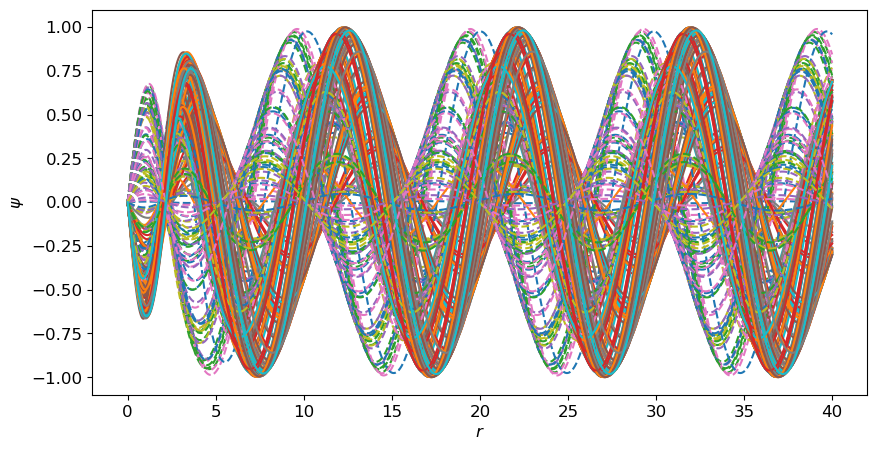

In [100]:
#extract some frescox wavefunctions and plot to see what they look like.
wave_set = []
for i in range(len(a_comp)):
    #print(np.gradient(a_comp[i].get(b_comp[0]))[0])
    wave_keyed = a_comp[i].get(b_comp[l_val])
    wave_set.append(wave_keyed)
#print(np.shape(wave_set))


wave_rescaled = wave_set

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(nruns):
    ax.plot(r, np.imag(wave_set[i]), zorder=1,linestyle='--',label='imag')
    ax.plot(r, np.real(wave_set[i]), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

In [101]:
def Gamow_factor(l, eta):
    r'''This returns the... Gamow factor.
    See [Wikipedia](https://en.wikipedia.org/wiki/Gamow_factor).

    Parameters:
        l (int): angular momentum
        eta (float): Sommerfeld parameter (see
            [Wikipedia](https://en.wikipedia.org/wiki/Sommerfeld_parameter))
    
    Returns:
        C_l (float): Gamow factor

    '''
    if eta == 0.0:
        if l == 0:
            return 1
        else:
            return 1 / (2*l + 1) * Gamow_factor(l-1, 0)
    elif l == 0:
        return np.sqrt(2*np.pi*eta / (np.exp(2*np.pi*eta)-1))
    else:
        return np.sqrt(l**2 + eta**2) / (l*(2*l+1)) * Gamow_factor(l-1, eta)


# def find_smallest_nonzero(wave):
#     '''
#     given an array, it finds the smallest value matchin the r0 condition bellow starting from the beginning. 
#     this will ensure we do not divide by 0.
#     '''
#     i = 1
#     if np.abs(wave[i]) != 0:
#         minimum = wave[i]
#         a = i
#     else:
#         while np.abs(wave[i]) == 0.0: ##condition
#             i += 1
#             minimum = wave[i]
#             a = i
#         #print(i)
#     return minimum, a

def find_smallest_nonzero(wave):
    '''
    given an array, it finds the smallest value matchin the r0 condition bellow starting from the beginning. 
    this will ensure we do not divide by 0.
    '''
    i = 0
    while np.abs(wave[i]) <= 1.0e-5: ##condition
        i += 1
        minimum = wave[i]
        a = i
        #print(i)
    return minimum, a

def rescaling_function(wave,keys,l):
    '''
    normalizes the wave near zero in this manner: 
    psi' = C_l*psi*r0^(l+1)/psi(r0)
    '''
    mini, i0 = find_smallest_nonzero(wave[0].get(keys[l]))
    wave_res = []
    for i in range(len(wave)):
        w_keyed = Gamow_factor(l,0)*((r[i0])**(l+1))*(wave[i].get(keys[l]))/(wave[i].get(keys[l]))[i0]
        wave_res.append(w_keyed)
    return np.array(wave_res)

def rescaling_function_free(wave,keys,l):
    '''
    normalizes the wave near zero in this manner: 
    psi' = C_l*psi*r0^(l+1)/psi(r0)
    '''
    mini, i0 = find_smallest_nonzero(wave.get(keys[l]))
    wave_res = []
    w_keyed = Gamow_factor(l,0)*((r[i0])**(l+1))*(wave.get(keys[l]))/(wave.get(keys[l]))[i0]
    return np.array(w_keyed)

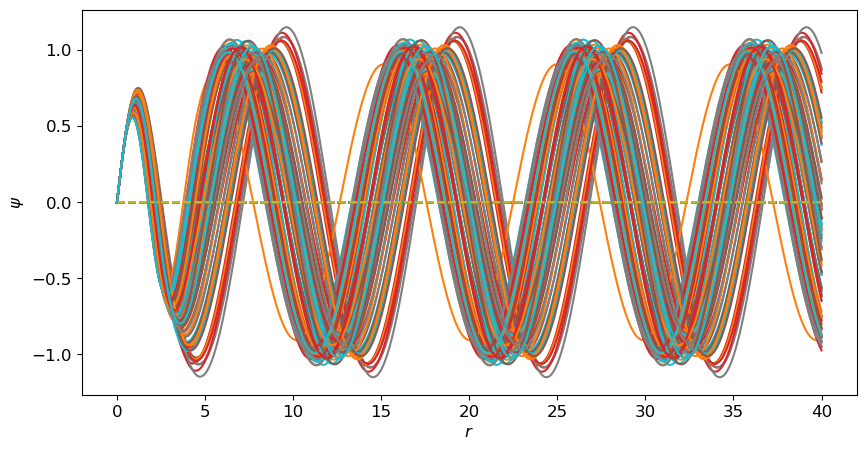

In [102]:
rescaled_wave = rescaling_function(a_comp,b_comp,l_val)

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(nruns):
    ax.plot(r, np.imag(rescaled_wave[i]), zorder=1,linestyle='--',label='imag')
    ax.plot(r, np.real(rescaled_wave[i]), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

In [103]:
def frescox_output_inelastic_wavefunctions_free(input_file='frescox_inputs/12C_n_free.in'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/12C_n_free.in > frescox_outputs/12C_n_free.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)
    
    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary('fort.17')
    
        
    
    return waves, keys

def frescox_run_inelastic_waves_free():
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries.
    '''
    waves_per_calc, keys_per_calc  = frescox_output_inelastic_wavefunctions_free()

    return waves_per_calc, keys_per_calc

In [104]:
def generate_second_derivative_matrix_9point(xgrid):
    '''
    For a given grid of points, compute the second derivative in 7 points
    '''
    N = len(xgrid)
    dx = xgrid[1] - xgrid[0]

    # Generate the matrix for the second derivative using a seven-point stencil
    main_diag = np.ones(N) * (-205.0 / 72.0 / dx**2)
    off_diag = np.ones(N - 1) * (8.0 / 5.0 / dx**2)
    off_diag2 = np.ones(N - 2) * (-1.0/ 5.0 / dx**2)
    off_diag3 = np.ones(N - 3) * (8.0 / 315.0 / dx**2)
    off_diag4 = np.ones(N - 4) * (-1.0 / 560.0 / dx**2)

    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2) + np.diag(off_diag3, k=3) + np.diag(off_diag3, k=-3) + np.diag(off_diag4, k=4) + np.diag(off_diag4, k=-4) 
    
    # One-sided approximations near boundaries
    D2[0, :9] = np.array([29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[1, :10] = np.array([0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[2, :11] = np.array([0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[3, :12] = np.array([0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[4, :13] = np.array([0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[5, :14] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[6, :15] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[7, :16] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2

    
    return D2

def wood_saxon_potential(x,alpha):
    '''
    From the previously defined angular momentum components of the deformation introduce a deformation
    parametrized by  "beta2"
    '''
    depth, radius, difuseness= alpha
    #R = R0 #- beta2*(sp.sph_harm(m_deform, l_deform, phi, theta))
    return (-depth/(1 + np.exp((x - radius*mass_coeff)/difuseness)))

In [105]:
def SVD_extract_frescox_asymp(theta,nbasis,xgrid):
    '''
    this function takes as an input the array of paramters to solve, and extracts the wavefunctions from fresco
    as a dictionary, then uses the dictionary keys to appropriately obtain the SVD components for each dictionary.
    The output is an array with the SVD basis components, in the same order of partial waves as the keys.
    '''
    waves, keys = frescox_run_elastic_waves(theta)
    free_waves, free_keys = frescox_run_inelastic_waves_free()
    D2 = generate_second_derivative_matrix_9point(xgrid)
    
    wave_set_free = []
    for j in range(len(free_keys)):
        l = int(free_keys[j][2])
        wave_free_keyed = rescaling_function_free(free_waves, free_keys, l)
        wave_set_free.append(wave_free_keyed)
    
    
    SVD_per_wave = []
    for j in range(len(keys)):
        l = int(keys[j][2])
        wave_set = rescaling_function(waves, keys, l)


        if (keys[j][1])==1.0:
            phi0 = wave_set_free[l]
            np_wave_set = (np.array(wave_set)- phi0).T
            #np_wave_set = (np.array(wave_set)).T
            U, S, Vt = np.linalg.svd(np_wave_set, full_matrices=False)
            basis = U[:, :nbasis]
            SVD_per_wave.append(basis)
            
#         else:
#             phi0 = wave_set_free[l]
#             np_wave_set = (np.array(wave_set)).T
#             U, S, Vt = np.linalg.svd(np_wave_set, full_matrices=False)
#             basis = U[:, :nbasis]
#             SVD_per_wave.append(basis)
        else:
            exit()
            
    SVD_per_wave_d2 = D2@np.array(SVD_per_wave).T
    wave_set_free_d2 = D2@np.array(wave_set_free).T
            
            
        
    return SVD_per_wave, keys, wave_set_free, SVD_per_wave_d2, wave_set_free_d2, D2

In [106]:
a_asym,b_asym,free_w,d2_w,d20_w,D2 = SVD_extract_frescox_asymp(theta_tr,basis,r)

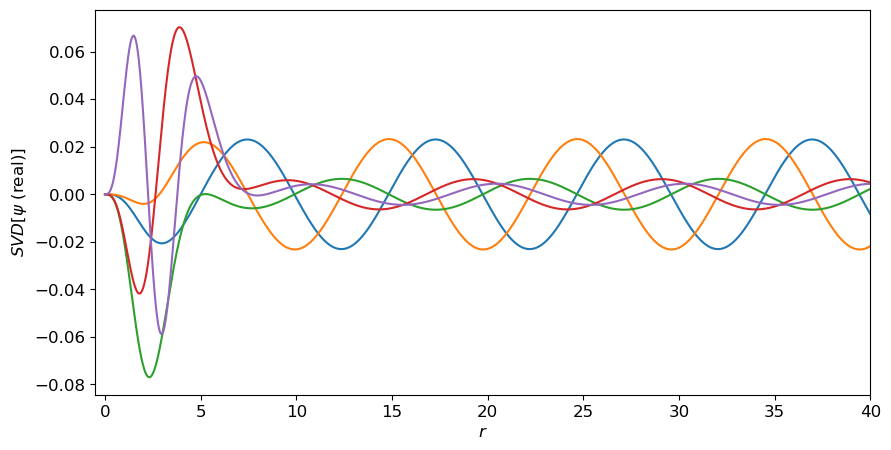

In [107]:
#plot the partial waves SVD

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(5):
    ax.plot(r, np.real(a_asym[l_val]).T[i], zorder=1)
    #ax.plot(r, np.real(a[0]).T[i], zorder=1,linestyle='--')
plt.xlabel(r'$r$')
plt.ylabel(r'$SVD[\psi$ (real)]')
#ax.set_yscale('log')
plt.xlim(-0.5,40)
pylab.show()
#print(b_asym)

In [108]:
theta_solv = latin_sampling_3(20)

In [109]:
def rescaling_function_emu(wave,l):
    '''
    normalizes the wave near zero in this manner: 
    psi' = C_l*psi*r0^(l+1)/psi(r0)
    '''
    mini, i0 = find_smallest_nonzero(wave)
    wave_res = []
    w_keyed = Gamow_factor(l,0)*((r[i0])**(l+1))*(wave)/(wave)[i0]
    return np.array(w_keyed)

def centri(l,x):
    '''with a radia grid x, generate an array containing the centrifugal potential'''
        
    if x[0] == 0:
        x[0] = 1
        cent = (l*(l+1))/(x**2)
        cent[0] = 0.0
        x[0] = 0
        print(cent)
    
    else:
        cent = (l*(l+1))/(x**2)
    
    return cent

In [110]:
def phase_shifts_exact(solving_points,x,match):
    sol,keys = frescox_run_elastic_waves(solving_points)
    wave_set = []
    phase_arr = []
    for l in range(len(keys)):
        wave_set_per_l = []
        phase_shift_per_l = []
        for i in range(len(sol)):
            wave_keyed = sol[i].get(keys[l])
            phase_shift = phase_shift_interp(u=wave_keyed,s=x,ell=l,x0=match)
            wave_set_per_l.append(wave_keyed)
            phase_shift_per_l.append(phase_shift)
        wave_set.append(wave_set_per_l)
        phase_arr.append( phase_shift_per_l)
    return wave_set, phase_arr

In [111]:
def emulation_multiple_l_trained(s_mesh,energ, nbasis, training_points, interaction, 
                                 solving_points, keys, SVD_l, phi_0_per_l, der2, der20, D2):
    
    '''
    If the emulator has been trained, the pass the outputs of the training to this functions, as well as the
    l_max, the number of basis, the interaction, and the solving points. This will then emulate the exact solution.
    This function has been checked for speed. 
    '''
    drop = 4
    #SVD_l, phi_0_per_l = SVD_multiple_l(s_mesh, energy, l_max, nbasis, training_points)
    phase_shift = []
    coeffs = []
    emu_wave = []
    #print(np.shape(SVD_l))
        
    for l in range(len(keys)):
        basis = SVD_l[l]
        phi_0 = phi_0_per_l[l]
        #print(np.shape(basis))
        psi = SVD_l[l]
        centrifugal = np.array([centri(l,s_mesh)])
        d2 = der2.T[l]
#        d2 = (D2 @ basis)
        
        d20 = der20.T[l]
            
        phase_shift_per_l = []
        emu_per_l = []
        coeffs_per_l = []
            
        for theta in solving_points:
            utilde = interaction(s_mesh, theta)[:, np.newaxis]
            A_right = -hbar2_mu*d2[drop:-drop] + hbar2_mu*centrifugal.T[drop:-drop]*basis[drop:-drop] +utilde[drop:-drop]*basis[drop:-drop] - energ*basis[drop:-drop]
            A = psi[drop:-drop].T @ A_right
            #A = basis[drop:-drop].T @ A_right
            #print(A)
            b = -psi[drop:-drop].T @ (-hbar2_mu*d20[drop:-drop]  + hbar2_mu*centrifugal[0][drop:-drop]*phi_0[drop:-drop] + utilde[drop:-drop].T[0]*phi_0[drop:-drop] - energ*phi_0[drop:-drop])
            a = np.linalg.solve(A, b)
            #print(a*(10**(-12)))
            emu = np.sum(a * basis, axis=1) + phi_0
            #print(np.shape(emu))
            #print(emu)
            rescaled_emu = rescaling_function_emu(emu,l)
            #rescaled_emu = emu
            phase_emu = phase_shift_interp(u=emu,s=s_mesh,ell=l,x0=18)
                
            coeffs_per_l.append(a)
            emu_per_l. append(rescaled_emu)
            phase_shift_per_l.append(phase_emu)
                
        phase_shift.append(phase_shift_per_l)
        coeffs.append(coeffs_per_l)
        emu_wave.append(emu_per_l)
            
    return phase_shift, coeffs, SVD_l, D2, phi_0_per_l, emu_wave

In [112]:
phase, gk_coeffs, base, D2, free, emulated = emulation_multiple_l_trained(r,energy, basis, theta_tr, wood_saxon_potential, 
                                 theta_solv, b_asym, a_asym,free_w, d2_w, d20_w, D2)


[0. 0. 0. ... 0. 0. 0.]


/var/folders/75/224k9cg92zsf79lm3_4nlxyw0000gn/T/ipykernel_61558/2015851370.py:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  rl = 1 / x0 * (u_func(x0) / derivative(u_func, x0, dx=dx))
/var/folders/75/224k9cg92zsf79lm3_4nlxyw0000gn/T/ipykernel_61558/2015851370.py:40: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_minus(z, ell), rho, dx=dx)
/var/folders/75/224k9cg92zsf79lm3_4nlxyw0000gn/T/ipykernel_61558/2015851370.py:33: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider usi

[0.00000000e+00 2.00000000e+04 5.00000000e+03 ... 1.25125094e-03
 1.25062523e-03 1.25000000e-03]
[0.00000000e+00 6.00000000e+04 1.50000000e+04 ... 3.75375281e-03
 3.75187570e-03 3.75000000e-03]
[0.00000000e+00 1.20000000e+05 3.00000000e+04 ... 7.50750563e-03
 7.50375141e-03 7.50000000e-03]


In [113]:
sol_waves, sol_keys = frescox_run_elastic_waves(theta_solv)
sol_rescaled = rescaling_function(sol_waves,sol_keys,l_val)
waves_ex, phase_ex = phase_shifts_exact(theta_solv,r,18.0)

/var/folders/75/224k9cg92zsf79lm3_4nlxyw0000gn/T/ipykernel_61558/2015851370.py:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  rl = 1 / x0 * (u_func(x0) / derivative(u_func, x0, dx=dx))
/var/folders/75/224k9cg92zsf79lm3_4nlxyw0000gn/T/ipykernel_61558/2015851370.py:40: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_minus(z, ell), rho, dx=dx)
/var/folders/75/224k9cg92zsf79lm3_4nlxyw0000gn/T/ipykernel_61558/2015851370.py:33: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider usi

In [114]:
phase_diff = np.abs(np.array(phase) - np.array(phase_ex))

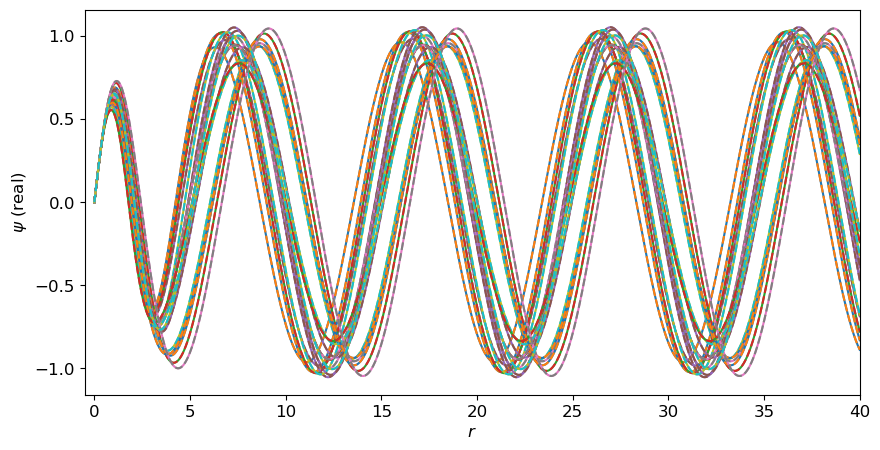

In [115]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(20):
    ax.plot(r, np.real(sol_rescaled[i]), zorder=1)
    ax.plot(r, np.real(emulated[l_val][i]), zorder=1,linestyle='--')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
#ax.set_yscale('log')
plt.xlim(-0.5,40)
pylab.show()
#print(b_asym)

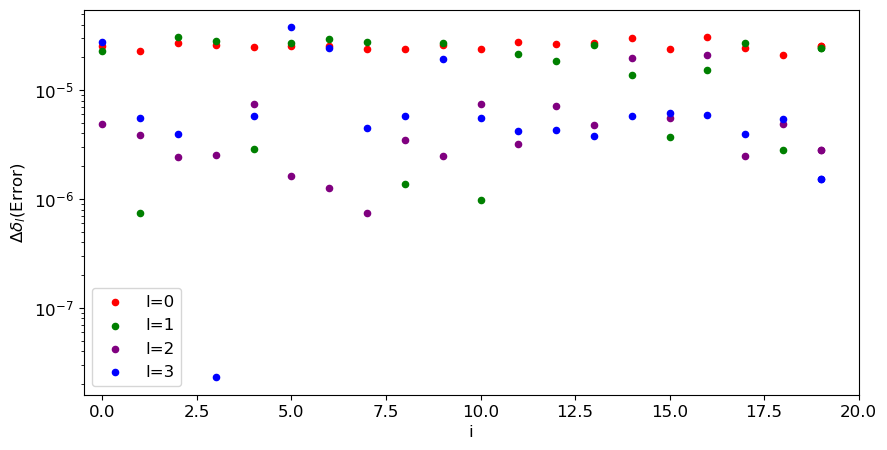

In [116]:
#plot the partial waves SVD, see the fuzzy behavior seen.

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(20):
    ax.scatter(i, (phase_diff[0][i]),s=20,color='r')
    ax.scatter(i, phase_diff[1][i],s=20,color='g')
    ax.scatter(i, phase_diff[2][i],s=20,color='purple')
    ax.scatter(i, phase_diff[3][i],s=20,color='b')
    
ax.scatter(i, phase_diff[0][i],s=20,color='r',label='l=0')
ax.scatter(i, phase_diff[1][i],s=20,color='g',label='l=1')
ax.scatter(i, phase_diff[2][i],s=20,color='purple',label='l=2')
ax.scatter(i, phase_diff[3][i],s=20,color='b',label='l=3')

ax.legend()

plt.xlabel(r'i')
plt.ylabel(r'$\Delta\delta_l$(Error)')
ax.set_yscale('log')
plt.xlim(-0.5,20)
pylab.show()